In [68]:
import xml.etree.cElementTree
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import subprocess
import os
%matplotlib inline

from IPython.display import clear_output
from scipy.interpolate import interp1d



# --------------- Latex Plot Beautification --------------------------
fig_width = 6
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 16,
          'font.size': 16,
          'legend.fontsize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------




In [88]:
## Generate input file:
# Let's figure out the source location given an incident angle!
D2R = np.pi/180.
aperture_entry = np.array([0,0,2.5])

r = 2
# Angle vector
tvec = -1*np.arange(0,20,1)
evec = [30e3, 100e3, 200e3, 500e3, 1e6] # photon energy, ev
# evec = [1e6] # photon energy, ev




filename = "photon_sweep.mac"
n_runs = 100000

# histogram settings:
hmin = 30e3 #ev
hmax = 2e6 #ev
nh   = 100

with open(filename,'w') as file:
    file.write("# Autogenerated by photon_angular_response_sweep.ipynb\n")
    # Preliminary setup:

    # Disable all the chatter
#     file.write('/run/numberOfThreads 8\n')
    file.write('/run/initialize\n')
    file.write('/control/verbose 0\n')
    file.write('/run/verbose 0\n')
    file.write('/event/verbose 0\n')
    file.write('/tracking/verbose 0\n\n')
    
    # General particle source:

    file.write('/gps/particle gamma\n')
#     file.write('/gps/polarization 0 0 0\n')
    file.write('/gps/pos/type Plane\n')
    file.write('/gps/pos/shape Circle\n')
    file.write('/gps/pos/radius 2.2 mm\n\n')
    
    file.write('/run/setCut 0.01 mm\n')
#     file.write('/analysis/setHistoDirName photon_sweep_histograms\n\n')
    # Histograms:
#     file.write('/analysis/setHistoDirName photon_sweep_histograms\n')
    file.write('/analysis/h1/create "h1" "Energy, from source,    ev" %d %d %d eV log10\n'%(nh, hmin, hmax))
    file.write('/analysis/h1/create "h2" "Energy, main detector,  ev" %d %d %d eV log10\n'%(nh, hmin, hmax))
    file.write('/analysis/h1/create "h3" "Energy, right detector, ev" %d %d %d eV log10\n'%(nh, hmin, hmax))
    file.write('/analysis/h1/create "h4" "Energy, left detector,  ev" %d %d %d eV log10\n\n'%(nh, hmin, hmax))
    file.write('/analysis/h1/create "h4" "Energy, right detector 2,  ev" %d %d %d eV log10\n\n'%(nh, hmin, hmax))


    for energy in evec:
        for theta in tvec:
            origin = aperture_entry + r*np.array([0, np.sin(theta*D2R), np.cos(theta*D2R)])
            direction = (aperture_entry - origin)
            direction = direction/np.linalg.norm(direction)
            file.write('# %d eV energy, %g degree offset\n'%(energy, theta))
            file.write('/gps/energy %d eV\n'%energy)
            file.write("/gps/position %2.4g %2.4g %2.4g cm\n"%(origin[0], origin[1], origin[2]))
            file.write("/gps/direction %2.4g %2.4g %2.4g cm\n"%(direction[0], direction[1], direction[2]))
            file.write('/gps/pos/type Plane\n')
            file.write('/gps/pos/shape Circle\n')
            file.write('/gps/pos/radius 1 mm\n\n')
            file.write("/analysis/setFileName photon_sweep_%d_ev_%g_deg\n"%(energy,theta))
            file.write("\n")
            file.write("/run/beamOn %d\n"%n_runs)
            file.write("\n")

In [47]:
def load_histo_file(filename):    
    hists = dict()
    axes  = dict()
    underflows = dict()
    overflows = dict()
    
    e = xml.etree.cElementTree.parse(filename).getroot()

    for hist in e.findall('histogram1d'):
        axis_info = hist.findall('axis')[0].attrib
#         print axis_info
        bin_vals = pow(10,np.linspace(float(axis_info['min']), float(axis_info['max']), int(axis_info['numberOfBins'])))
#         bin_vals = np.linspace(float(axis_info['min']), float(axis_info['max']), int(axis_info['numberOfBins']))


        title = hist.attrib['title']

    #     print bin_vals
        cur_hist = np.zeros_like(bin_vals)
        for cell in hist.findall('data1d')[0]:
            try:
                binN=int(cell.attrib['binNum'])
                binH=int(cell.attrib['height'])
                cur_hist[binN] = binH
            except:
                if 'UNDERFLOW' in cell.attrib['binNum']:
                    underflows[title] = int(cell.attrib['height'])
                if 'OVERFLOW' in cell.attrib['binNum']:
                    overflows[title] = int(cell.attrib['height'])
        hists[title] = cur_hist
        axes[title]  = bin_vals

        print title, " has", np.sum(cur_hist), "values"
    return hists, axes, underflows, overflows



['photon_sweep_1000000_ev_-10_deg.xml', 'photon_sweep_1000000_ev_-11_deg.xml', 'photon_sweep_1000000_ev_-1_deg.xml', 'photon_sweep_1000000_ev_-2_deg.xml', 'photon_sweep_1000000_ev_-3_deg.xml', 'photon_sweep_1000000_ev_-4_deg.xml', 'photon_sweep_1000000_ev_-5_deg.xml', 'photon_sweep_1000000_ev_-6_deg.xml', 'photon_sweep_1000000_ev_-7_deg.xml', 'photon_sweep_1000000_ev_-8_deg.xml', 'photon_sweep_1000000_ev_-9_deg.xml', 'photon_sweep_1000000_ev_0_deg.xml', 'photon_sweep_100000_ev_-10_deg.xml', 'photon_sweep_100000_ev_-11_deg.xml', 'photon_sweep_100000_ev_-1_deg.xml', 'photon_sweep_100000_ev_-2_deg.xml', 'photon_sweep_100000_ev_-3_deg.xml', 'photon_sweep_100000_ev_-4_deg.xml', 'photon_sweep_100000_ev_-5_deg.xml', 'photon_sweep_100000_ev_-6_deg.xml', 'photon_sweep_100000_ev_-7_deg.xml', 'photon_sweep_100000_ev_-8_deg.xml', 'photon_sweep_100000_ev_-9_deg.xml', 'photon_sweep_100000_ev_0_deg.xml', 'photon_sweep_200000_ev_-10_deg.xml', 'photon_sweep_200000_ev_-11_deg.xml', 'photon_sweep_200000_

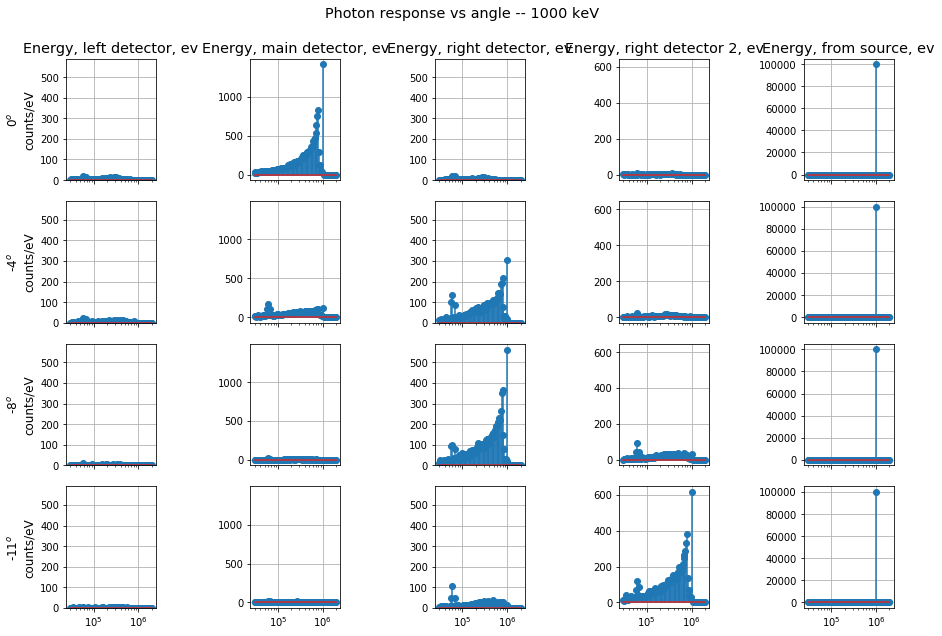

In [22]:
# Plot the results:
# --------------- Latex Plot Beautification --------------------------
fig_width = 12
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


d = os.listdir('.')
files = [x for x in d if x.startswith('photon_sweep') and x.endswith(".xml")]
print files
angles = [0, -4, -8, -11]
# energies = [30e3]
energy = 1e6
column_ymax = [1000, 10000, 1000, 10000]

for energy in [evec[-1]]:
    fig, ax = plt.subplots(len(angles), 5, sharex='col', sharey='col')


    for angle_ind, angle in enumerate(angles):
    #     filename = 'electron_%d_deg.xml'%angle
        filename = "photon_sweep_%d_ev_%g_deg.xml"%(energy, angle)
        hists, axes, underflows, overflows = load_histo_file(filename)
        print "-------"
        keylist = ['Energy, left detector, ev', 'Energy, main detector, ev', 'Energy, right detector, ev', 'Energy, right detector 2, ev','Energy, from source, ev']
        for k_ind, key in enumerate(keylist):

            ax[angle_ind, k_ind].stem(axes[key], hists[key],zorder=100, alpha=0.7)
            ax[angle_ind, k_ind].set_ylabel('counts')
            ax[angle_ind, k_ind].grid('on', zorder=0)

            ax[angle_ind, k_ind].set_xscale('log')
            ax[0, k_ind].set_title(key)
            ax[angle_ind, k_ind].set_ylabel('')

        ax[angle_ind, 0].set_ylabel('%d$^o$\ncounts/eV'%angle)


    # Set yscales:
    maxy_0 = 0
    maxy_1 = 0
    for x in range(len(angles)):
        maxy_0 = max(maxy_0, ax[x,0].get_ylim()[1])
        maxy_0 = max(maxy_0, ax[x,2].get_ylim()[1])
        maxy_1 = max(maxy_1, ax[x,1].get_ylim()[1])
        maxy_1 = max(maxy_1, ax[x,3].get_ylim()[1])

    maxy_0 = np.ceil(maxy_0/10)*10
    maxy_1 = np.ceil(maxy_1/10)*10
    for x in range(len(angles)):
        ax[x,0].set_ylim([0,maxy_0])
        ax[x,2].set_ylim([0,maxy_0])
#         ax[x,1].set_ylim([0,maxy_1])
#         ax[x,3].set_ylim([0,maxy_1])

    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Photon response vs angle -- %d keV'%(energy/1000.))
    figname = 'photon_response_%1.0e_ev.png'%energy
    fig.savefig(figname, dpi=300)



In [80]:
maxy_0 = 0
maxy_1 = 0
for x in range(len(angles)):
    maxy_0 = max(maxy_0, ax[x,0].get_ylim()[1])
    maxy_0 = max(maxy_0, ax[x,2].get_ylim()[1])
    maxy_1 = max(maxy_1, ax[x,1].get_ylim()[1])
    maxy_1 = max(maxy_1, ax[x,3].get_ylim()[1])

maxy_0 = np.ceil(maxy_0/10)*10
maxy_1 = np.ceil(maxy_1/10)*10
for x in range(len(angles)):
    ax[x,0].set_ylim([0,maxy_0])
    ax[x,2].set_ylim([0,maxy_0])
    ax[x,1].set_ylim([0,maxy_1])
    ax[x,3].set_ylim([0,maxy_1])
# print maxy_0
# print maxy_1

figname = 'photon_response_%1.0e_ev.png'%energy
print figname




photon_response_1e+06_ev.png


In [94]:
filename = "photon_sweep_%d_ev_%g_deg.xml"%(5e5, 0)
hists, axes, underflows, overflows = load_histo_file(filename)

{'max': '6.301029995663981253528618', 'direction': 'x', 'numberOfBins': '100', 'min': '4.477121254719662601928576'}
Energy, from source, ev  has 100000.0 values
{'max': '6.301029995663981253528618', 'direction': 'x', 'numberOfBins': '100', 'min': '4.477121254719662601928576'}
Energy, main detector, ev  has 60252.0 values
{'max': '6.301029995663981253528618', 'direction': 'x', 'numberOfBins': '100', 'min': '4.477121254719662601928576'}
Energy, right detector, ev  has 4681.0 values
{'max': '6.301029995663981253528618', 'direction': 'x', 'numberOfBins': '100', 'min': '4.477121254719662601928576'}
Energy, left detector, ev  has 4713.0 values


[0.007 0.008 0.006 0.007 0.008 0.011 0.015 0.011 0.014 0.017 0.021 0.02
 0.018 0.029 0.076 0.17  0.423 0.773 1.11  1.321]


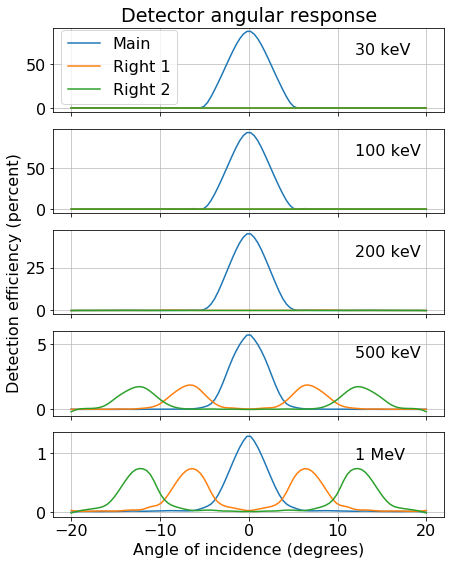

In [119]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 6
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 16,
          'font.size': 16,
          'legend.fontsize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

# Plot detector response vs. angle:
directory = '.'
d = os.listdir(directory)
files = [x for x in d if x.startswith('photon_sweep_') and x.endswith('.xml')]
energies = np.array(sorted(np.unique([float(f.split('_')[2]) for f in files])))
angles = np.array(sorted(np.unique([(float(f.split('_')[4])) for f in files])))

fig, ax = plt.subplots(len(energies),1, sharex=True)
# energy = energies[0]

for e_ind, energy in enumerate(energies):
    main_detector = []
    right_detector= []
    right_detector_2 = []
    left_detector = []
    for angle_ind, angle in enumerate(angles):
        filename = os.path.join(directory,'photon_sweep_%d_ev_%g_deg.xml'%(energy,angle))
        hists, axes, underflows, overflows = load_histo_file(filename)
        print "---"
        print hists.keys()
        runtotal = np.sum(hists['Energy, from source, ev'])
        measured_val = max(hists['Energy, main detector, ev'])
        detection_efficiency = 100.*(measured_val/runtotal)
        main_detector.append(detection_efficiency)

        measured_val = max(hists['Energy, right detector, ev'])
        detection_efficiency = 100.*(measured_val/runtotal)
        right_detector.append(detection_efficiency)

        measured_val = max(hists['Energy, right detector 2, ev'])
        detection_efficiency = 100.*(measured_val/runtotal)
        right_detector_2.append(detection_efficiency)
        
        measured_val = max(hists['Energy, left detector, ev'])
        detection_efficiency = 100.*(measured_val/runtotal)
        left_detector.append(detection_efficiency)

    main_detector = np.array(main_detector)
    right_detector = np.array(right_detector)
    right_detector_2 = np.array(right_detector_2)
    left_detector = np.array(left_detector)
    
    clear_output(wait=True)
    print main_detector
    new_angles = np.linspace(-20,20,100)
    interp = interp1d(np.abs(angles), main_detector, bounds_error=False, kind='cubic',fill_value='extrapolate')
    new_values = interp(np.abs(new_angles))
    ax[e_ind].plot(new_angles, new_values, label='Main')

    interp = interp1d(np.abs(angles), right_detector, bounds_error=False, kind='cubic',fill_value='extrapolate')
    new_values = interp(np.abs(new_angles))
    ax[e_ind].plot(new_angles, new_values, label='Right 1')

    interp = interp1d(np.abs(angles), right_detector_2, bounds_error=False, kind='cubic',fill_value='extrapolate')
    new_values = interp(np.abs(new_angles))
    ax[e_ind].plot(new_angles, new_values, label = 'Right 2')
    
#     interp = interp1d(np.abs(angles), left_detector, bounds_error=False, kind='cubic',fill_value='extrapolate')
#     new_values = interp(np.abs(new_angles))
#     ax[e_ind].plot(new_angles, new_values, label = 'Left')
    
    

    if energy < 1e6:
        ax[e_ind].text(12,ax[e_ind].get_ylim()[1]/1.5,'%g keV'%(energy/1000))
    elif energy >= 1e6:
        ax[e_ind].text(12,ax[e_ind].get_ylim()[1]/1.5,'%g MeV'%(energy/1000/1000))

    ax[e_ind].grid('on', which='both', alpha=0.8)
ax[2].set_ylabel('Detection efficiency (percent)')
ax[0].legend()

ax[-1].set_xlabel('Angle of incidence (degrees)')

ax[0].set_title('Detector angular response')
fig.savefig('angular_response_with_side_detectors.pdf')


[0.007 0.008 0.006 0.007 0.008 0.011 0.015 0.011 0.014 0.017 0.021 0.02
 0.018 0.029 0.076 0.17  0.423 0.773 1.11  1.321]


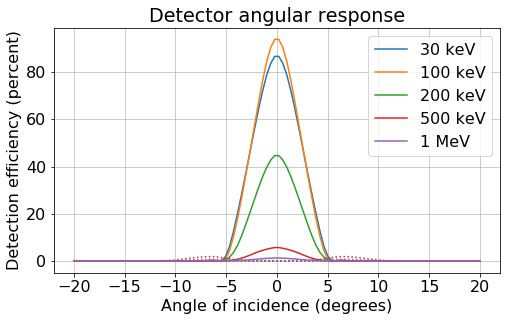

In [113]:

# --------------- Latex Plot Beautification --------------------------
fig_width = 7
fig_height = 3.5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 16,
          'font.size': 16,
          'legend.fontsize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


# Plot detector response vs. angle:
directory = '.'
d = os.listdir(directory)
files = [x for x in d if x.startswith('photon_sweep_') and x.endswith('.xml')]
energies = np.array(sorted(np.unique([float(f.split('_')[2]) for f in files])))
angles = np.array(sorted(np.unique([(float(f.split('_')[4])) for f in files])))

fig, ax = plt.subplots(1,1)
# energy = energies[0]

for e_ind, energy in enumerate(energies):
    main_detector = []
    right_detector= []
    right_detector_2 = []
    for angle_ind, angle in enumerate(angles):
        filename = os.path.join(directory,'photon_sweep_%d_ev_%g_deg.xml'%(energy,angle))
        hists, axes, underflows, overflows = load_histo_file(filename)
        print "---"
        print hists.keys()
        runtotal = np.sum(hists['Energy, from source, ev'])
        measured_val = max(hists['Energy, main detector, ev'])
        detection_efficiency = 100.*(measured_val/runtotal)
        main_detector.append(detection_efficiency)

        measured_val = max(hists['Energy, right detector, ev'])
        detection_efficiency = 100.*(measured_val/runtotal)
        right_detector.append(detection_efficiency)

        measured_val = max(hists['Energy, right detector 2, ev'])
        detection_efficiency = 100.*(measured_val/runtotal)
        right_detector_2.append(detection_efficiency)

    main_detector = np.array(main_detector)
    right_detector = np.array(right_detector)
    right_detector_2 = np.array(right_detector_2)

    clear_output(wait=True)
    print main_detector
    new_angles = np.linspace(-20,20,100)
    interp = interp1d(np.abs(angles), main_detector, bounds_error=False, kind='cubic',fill_value='extrapolate')
    new_values = interp(np.abs(new_angles))
    
    
    color=plt.cm.Vega10(e_ind)
    if energy < 1e6:
        label = '%g keV'%(energy/1000)
    elif energy >= 1e6:
        label = '%g MeV'%(energy/1000/1000)
    ax.plot(new_angles, new_values, label=label, color=color)

    interp = interp1d(np.abs(angles), right_detector, bounds_error=False, kind='cubic',fill_value='extrapolate')
    new_values = interp(np.abs(new_angles))
    ax.plot(new_angles, new_values,':', color=color)

#     interp = interp1d(np.abs(angles), right_detector_2, bounds_error=False, kind='cubic',fill_value='extrapolate')
#     new_values = interp(np.abs(new_angles))
#     ax[e_ind].plot(new_angles, new_values, label = 'Right 2')

#     if energy < 1e6:
#         ax[e_ind].text(12,ax[e_ind].get_ylim()[1]/1.5,'%g keV'%(energy/1000))
#     elif energy >= 1e6:
#         ax[e_ind].text(12,ax[e_ind].get_ylim()[1]/1.5,'%g MeV'%(energy/1000/1000))

ax.grid('on', which='both', alpha=0.8)

ax.set_ylabel('Detection efficiency (percent)')
ax.legend()

ax.set_xlabel('Angle of incidence (degrees)')
ax.set_title('Detector angular response')
fig.savefig('angular_response_central_detector.pdf')